In [93]:
# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
import seaborn as sns

# Configure NumPy's print options for backward compatibility
np.set_printoptions(legacy='1.25')

# Import scikit-learn modules for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

In [94]:
# File path for the dataset
dataset_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Check if the dataset file already exists to avoid re-downloading
if os.path.exists(dataset_path):
    print("Dataset already exists. Loading from file...")
    df = pd.read_csv(dataset_path)
else:
    print("Dataset not found. Downloading...")
    df = pd.read_csv(dataset_path)

# Standardize column names: lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Identify categorical columns
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Convert 'totalcharges' to numeric, coercing errors to NaN
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Fill NaN values in 'totalcharges' with 0
df.totalcharges = df.totalcharges.fillna(0)

# Encode 'churn' column: 'yes' -> 1, 'no' -> 0
df.churn = (df.churn == 'yes').astype(int)

# Check for missing values in 'totalcharges' column
num_missing = df.totalcharges.isna().sum()
print(f"Total missing values in 'totalcharges': {num_missing}")

Dataset already exists. Loading from file...
Total missing values in 'totalcharges': 0


In [95]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Standardize column names: lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Identify categorical columns
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Clean categorical columns: lowercase and replace spaces with underscores
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Convert 'totalcharges' to numeric, coercing errors to NaN
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Fill NaN values in 'totalcharges' with 0
df.totalcharges = df.totalcharges.fillna(0)

# Encode 'churn' column: 'yes' -> 1, 'no' -> 0
df.churn = (df.churn == 'yes').astype(int)

num_missing = df.totalcharges.isna().sum()
print(f"Total missing values in 'totalcharges': {num_missing}")

Total missing values in 'totalcharges': 0


In [96]:
# Function to split the dataset and reset index
def prepare_datasets(df, target_col, test_size=0.2, val_size=0.25, random_state=1):
    # Split the dataset into train and test
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split the train dataset into training and validation sets
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset index for all datasets
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Separate features and target
    y_train = df_train[target_col].values
    y_val = df_val[target_col].values
    y_test = df_test[target_col].values
    
    # Drop target column from features
    df_train = df_train.drop(columns=[target_col])
    df_val = df_val.drop(columns=[target_col])
    df_test = df_test.drop(columns=[target_col])
    
    return df_train, df_val, df_test, y_train, y_val, y_test

# Usage
df_train, df_val, df_test, y_train, y_val, y_test = prepare_datasets(df, target_col='churn')

In [97]:
# Numerical feature columns
numerical = ['tenure', 'monthlycharges', 'totalcharges']

# Define categorical feature columns
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [98]:
# DictVectorizer for categorical and numerical feature transformation
dv = DictVectorizer(sparse=False)

# Convert training data to dictionary format for DictVectorizer
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Apply transformation to convert dictionaries into feature vectors
X_train = dv.fit_transform(train_dict)

# Scale the numerical features
scaler = StandardScaler()
X_train[:, -len(numerical):] = scaler.fit_transform(X_train[:, -len(numerical):])

# Logistic regression model with increased max_iter and alternative solver
model = LogisticRegression(max_iter=5000, solver='saga', C=0.1)

# Fit the model with training data
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=5000, solver='saga')

In [99]:
# Convert validation data to dictionary format for DictVectorizer
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Transform validation data using the fitted DictVectorizer
X_val = dv.transform(val_dict)

# Predict probabilities for the validation data
y_pred = model.predict_proba(X_val)[:, 1]

# Make churn decision based on probability threshold of 0.5
churn_decision = (y_pred >= 0.5)

# Calculate accuracy of the predictions
accuracy = (y_val == churn_decision).mean()

# Print validation
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 0.2761


In [100]:
# Print
print(f"Length of y_val: {len(y_val)}")

Length of y_val: 1409


In [101]:
# Calculate the number of correct predictions
correct_predictions = (y_val == churn_decision).sum()

# Print
print(f"Number of correct predictions: {correct_predictions}")

accuracy = (y_val == churn_decision).mean()
print(f"Validation accuracy: {accuracy:.4f}")

Number of correct predictions: 389
Validation accuracy: 0.2761


In [102]:
accuracy = 1132 / 1409
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8034


In [103]:
accuracy_score(y_val, y_pred >= 0.5)

0.27608232789212206

In [104]:
# Thresholds from 0 to 1 in steps of 0.05
thresholds = np.linspace(0, 1, 21)

# List to store accuracy scores for each threshold
scores = []

# Iterate over thresholds and calculate accuracy
for t in thresholds:
    # Make churn predictions based on the current threshold
    churn_decision = y_pred >= t
    
    # Calculate accuracy for the current threshold
    score = accuracy_score(y_val, churn_decision)
    
    # Print the threshold and corresponding accuracy
    print('Threshold: %.2f, Accuracy: %.3f' % (t, score))
    
    # Append the accuracy score to the list
    scores.append(score)

Threshold: 0.00, Accuracy: 0.274
Threshold: 0.05, Accuracy: 0.276
Threshold: 0.10, Accuracy: 0.276
Threshold: 0.15, Accuracy: 0.276
Threshold: 0.20, Accuracy: 0.276
Threshold: 0.25, Accuracy: 0.276
Threshold: 0.30, Accuracy: 0.276
Threshold: 0.35, Accuracy: 0.276
Threshold: 0.40, Accuracy: 0.276
Threshold: 0.45, Accuracy: 0.276
Threshold: 0.50, Accuracy: 0.276
Threshold: 0.55, Accuracy: 0.276
Threshold: 0.60, Accuracy: 0.276
Threshold: 0.65, Accuracy: 0.276
Threshold: 0.70, Accuracy: 0.276
Threshold: 0.75, Accuracy: 0.276
Threshold: 0.80, Accuracy: 0.276
Threshold: 0.85, Accuracy: 0.276
Threshold: 0.90, Accuracy: 0.276
Threshold: 0.95, Accuracy: 0.280
Threshold: 1.00, Accuracy: 0.288


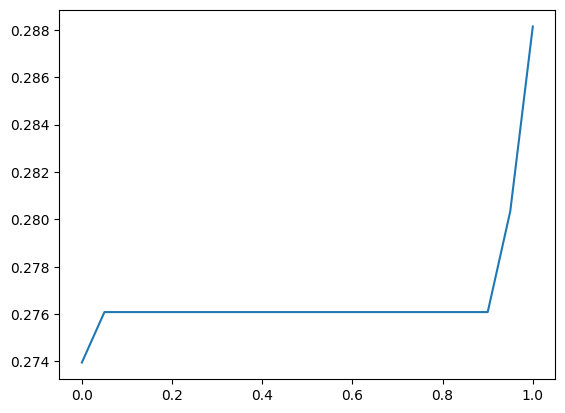

In [105]:
plt.plot(thresholds, scores)

In [106]:
# Prediction that every custumers are not churning
Counter(y_pred >= 1.0) 

Counter({True: 1235, False: 174})

In [107]:
proportion_non_churn = 1 - y_val.mean()
print(f"Proportion of non-churn: {proportion_non_churn:.4f}")

Proportion of non-churn: 0.7260


In [108]:
# Count occurrences of each class in y_val
class_counts = Counter(y_val)

print(class_counts)

Counter({0: 1023, 1: 386})


In [109]:
# Boolean masks for actual positive and negative instances
actual_positive = (y_val == 1)  # Instances where churn occurred
actual_negative = (y_val == 0)  # Instances where churn did not occur

# Print number of actual positives and negatives
print(f"Number of actual positive (churn) cases: {actual_positive.sum()}")
print(f"Number of actual negative (non-churn) cases: {actual_negative.sum()}")

Number of actual positive (churn) cases: 386
Number of actual negative (non-churn) cases: 1023


In [110]:
# Set threshold for churn prediction
t = 0.5

# Create boolean masks for predicted positive (churn) and predicted negative (non-churn)
predict_positive = (y_pred >= t)  # Predicted churn (True if probability >= 0.5)
predict_negative = (y_pred < t)   # Predicted non-churn (True if probability < 0.5)

# Print number of predicted positives and negatives
print(f"Number of predicted positive (churn) cases: {predict_positive.sum()}")
print(f"Number of predicted negative (non-churn) cases: {predict_negative.sum()}")

Number of predicted positive (churn) cases: 1406
Number of predicted negative (non-churn) cases: 3


In [111]:
# Calculate True Positives (TP): Correctly predicted churn cases
tp = (predict_positive & actual_positive).sum()

# Calculate True Negatives (TN): Correctly predicted non-churn cases
tn = (predict_negative & actual_negative).sum()

# Calculate False Positives (FP): Incorrectly predicted churn cases (predicted churn, actually non-churn)
fp = (predict_positive & actual_negative).sum()

# Calculate False Negatives (FN): Incorrectly predicted non-churn cases (predicted non-churn, actually churn)
fn = (predict_negative & actual_positive).sum()

# Print results
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 386
True Negatives (TN): 3
False Positives (FP): 1020
False Negatives (FN): 0


Confusion Matrix:
[[   3 1020]
 [   0  386]]


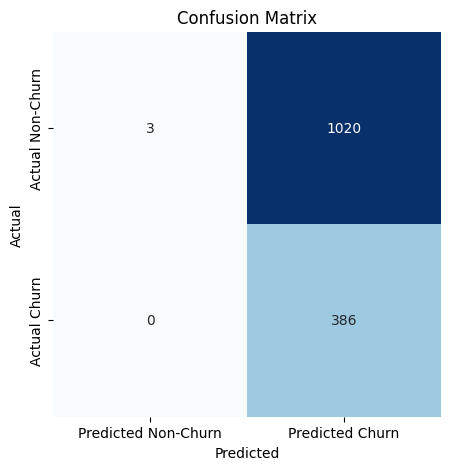

In [112]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

# Create confusion matrix as a 2x2 numpy array
confusion_matrix = np.array([[tn, fp], 
                             [fn, tp]])

# Print the confusion matrix values
print("Confusion Matrix:")
print(confusion_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Predicted Non-Churn", "Predicted Churn"], 
            yticklabels=["Actual Non-Churn", "Actual Churn"])

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Plot
plt.show()

In [113]:
# Create the confusion matrix
confusion_matrix = np.array([
    [tn, fp],  # Row for actual negative cases
    [fn, tp]   # Row for actual positive cases
])

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[   3 1020]
 [   0  386]]


In [114]:
# Normalize the confusion matrix by dividing each element by the total sum of the matrix
normalized_confusion_matrix = (confusion_matrix / confusion_matrix.sum()).round(2)

# Display normalized confusion matrix
print("Normalized Confusion Matrix:")
print(normalized_confusion_matrix)

Normalized Confusion Matrix:
[[0.   0.72]
 [0.   0.27]]


In [115]:
# Calculate precision
p = tp / (tp + fp)

# Display precision value
print(f"Precision: {p:.4f}")

Precision: 0.2745


In [116]:
# Calculate recall (sensitivity)
r = tp / (tp + fn)

# Display recall value
print(f"Recall: {r:.4f}")

Recall: 1.0000


In [117]:
# Calculate false positive rate (FPR)
fpr = fp / (fp + tn)

# Display false positive rate
print(f"False Positive Rate (FPR): {fpr:.4f}")

False Positive Rate (FPR): 0.9971


In [118]:
tpr = tp / (tp + fn)
tpr

1.0

In [119]:
# Initialize an empty list to store scores for each threshold
scores = []

# Define thresholds from 0 to 1 with 101 steps
thresholds = np.linspace(0, 1, 101)

# Loop over each threshold and calculate TP, FP, FN, TN
for t in thresholds:
    # Define actual positive and negative cases
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    # Define predicted positive and negative cases based on threshold t
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    # Calculate TP, TN, FP, FN
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # Append the threshold and the corresponding metrics to the scores list
    scores.append((t, tp, fp, fn, tn))

# Print the results
for score in scores:
    print(f"Threshold: {score[0]:.2f}, TP: {score[1]}, FP: {score[2]}, FN: {score[3]}, TN: {score[4]}")

Threshold: 0.00, TP: 386, FP: 1023, FN: 0, TN: 0
Threshold: 0.01, TP: 386, FP: 1023, FN: 0, TN: 0
Threshold: 0.02, TP: 386, FP: 1023, FN: 0, TN: 0
Threshold: 0.03, TP: 386, FP: 1023, FN: 0, TN: 0
Threshold: 0.04, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.05, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.06, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.07, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.08, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.09, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.10, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.11, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.12, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.13, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.14, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.15, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.16, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.17, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.18, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.19, TP: 386, FP: 1020, FN: 0, TN: 3
Threshold: 0.20, TP:

In [120]:
# Columns for the DataFrame
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

# Create a DataFrame from the scores list
df_scores = pd.DataFrame(scores, columns=columns)

# Calculate True Positive Rate (TPR) - also known as Recall or Sensitivity
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)

# Calculate False Positive Rate (FPR)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

# Display DataFrame
print(df_scores.head())

   threshold   tp    fp  fn  tn  tpr       fpr
0       0.00  386  1023   0   0  1.0  1.000000
1       0.01  386  1023   0   0  1.0  1.000000
2       0.02  386  1023   0   0  1.0  1.000000
3       0.03  386  1023   0   0  1.0  1.000000
4       0.04  386  1020   0   3  1.0  0.997067


In [121]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,1020,0,3,1.000000,0.997067
20,0.2,386,1020,0,3,1.000000,0.997067
30,0.3,386,1020,0,3,1.000000,0.997067
40,0.4,386,1020,0,3,1.000000,0.997067
50,0.5,386,1020,0,3,1.000000,0.997067
60,0.6,386,1020,0,3,1.000000,0.997067
70,0.7,386,1020,0,3,1.000000,0.997067
80,0.8,386,1020,0,3,1.000000,0.997067
90,0.9,386,1020,0,3,1.000000,0.997067


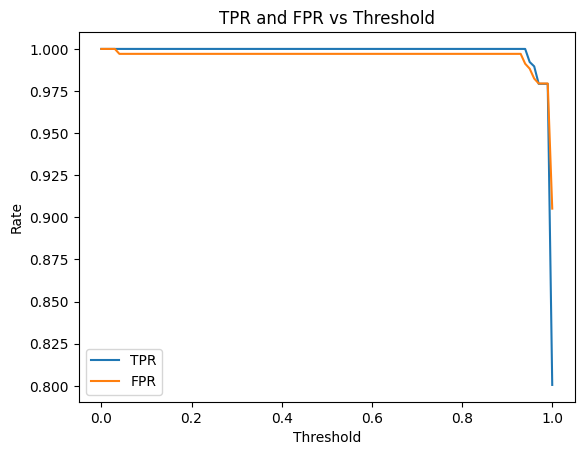

In [122]:
# Define columns for the DataFrame
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

# Create a DataFrame from the scores list
df_scores = pd.DataFrame(scores, columns=columns)

# Calculate True Positive Rate (TPR)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)

# Calculate False Positive Rate (FPR)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

# Plot TPR and FPR as functions of the threshold
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs Threshold')

# Plot
plt.show()

In [123]:
# Set the random seed for reproducibility
np.random.seed(1)

# Generate random uniform values between 0 and 1 with the same length as y_val
y_rand = np.random.uniform(0, 1, size=len(y_val))

# Round the generated values to 3 decimal places
y_rand_rounded = y_rand.round(3)

# Display rounded random values
print(y_rand_rounded)

[0.417 0.72  0.    ... 0.774 0.334 0.089]


In [124]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [125]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [126]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

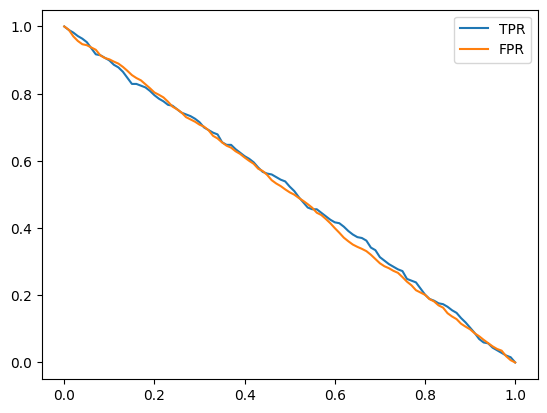

In [127]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

In [128]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [129]:
num_neg = 700
num_pos = 300 

y_ideal = np.repeat([0, 1], [num_neg, num_pos])

# Array
y_ideal_pred = np.linspace(0, 1, len(y_ideal))

# Display values
print("y_ideal:", y_ideal[:10])
print("y_ideal_pred:", y_ideal_pred[:10])

y_ideal: [0 0 0 0 0 0 0 0 0 0]
y_ideal_pred: [0.         0.001001   0.002002   0.003003   0.004004   0.00500501
 0.00600601 0.00700701 0.00800801 0.00900901]


In [130]:
1 - y_val.mean()

0.7260468417317246

In [131]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

0.974

In [132]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,300,700,0,0,1.000000,1.000000
10,0.1,300,600,0,100,1.000000,0.857143
20,0.2,300,500,0,200,1.000000,0.714286
30,0.3,300,400,0,300,1.000000,0.571429
40,0.4,300,300,0,400,1.000000,0.428571
50,0.5,300,200,0,500,1.000000,0.285714
60,0.6,300,100,0,600,1.000000,0.142857
70,0.7,300,0,0,700,1.000000,0.000000
80,0.8,200,0,100,700,0.666667,0.000000
90,0.9,100,0,200,700,0.333333,0.000000


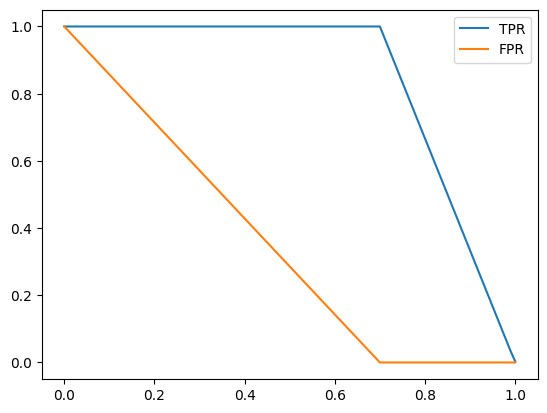

In [133]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

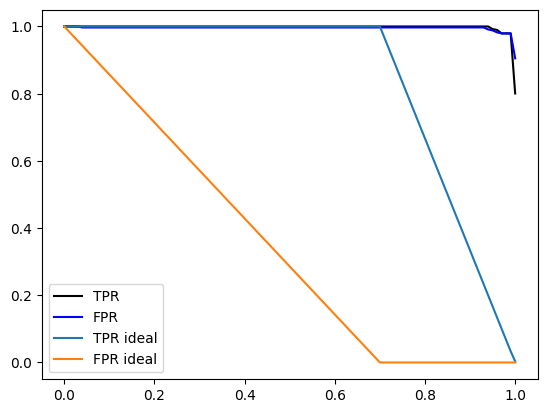

In [134]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.legend()

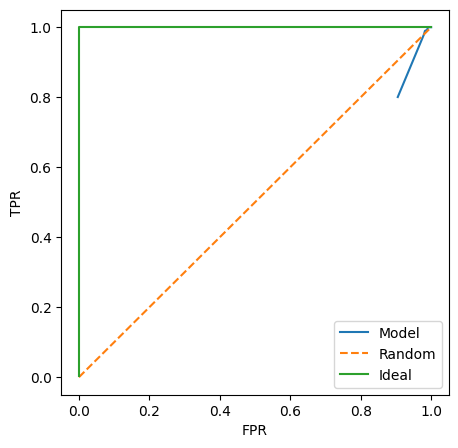

In [135]:
# Set the size of the figure to 5x5 inches
plt.figure(figsize=(5, 5))

# Plot the model's ROC curve (FPR vs. TPR)
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')

# Plot the diagonal line representing random guessing (chance level)
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

# Plot the ROC curve for the ideal model (perfect predictions)
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

# Label the x-axis as FPR (False Positive Rate)
plt.xlabel('FPR')

# Label the y-axis as TPR (True Positive Rate)
plt.ylabel('TPR')

# Display for the curves
plt.legend()

In [136]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

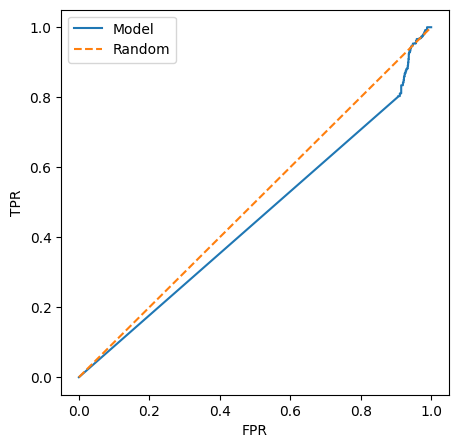

In [137]:
plt.figure(figsize=(5, 5))

# Plot the ROC curve of the model (FPR vs. TPR)
plt.plot(fpr, tpr, label='Model')

# Plot the diagonal line representing random guessing (FPR = TPR)
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

# Label the x-axis as False Positive Rate (FPR)
plt.xlabel('FPR')

# Label the y-axis as True Positive Rate (TPR)
plt.ylabel('TPR')

# Plot
plt.legend()